In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# k_fast,off (k_E) and k_slow,on (k_S)

In [4]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [5]:
# m = 4.037925
# n =	100
# alpha = 8.351984
# beta = 3.123359
# g =  442.699730/n
# tau_y = 0.050404

m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

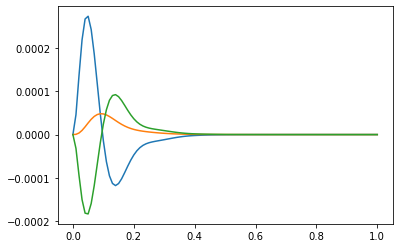

In [6]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

# LPOU input

In [7]:
# tot = 300
# tAxis = np.arange(0,tot,dt)
# # OU ; input
# tau = 1
# D = 1
# OU=np.zeros(len(tAxis))
# mu, sigma = 0, 1
# for i in range(len(tAxis)-1):
#     OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# # filtering for OUSmoothed
# Fc = 1
# b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
# LPOU = signal.filtfilt(b, a, OU)
# LPOU = (LPOU-np.mean(LPOU))/np.std(LPOU)
# x = LPOU

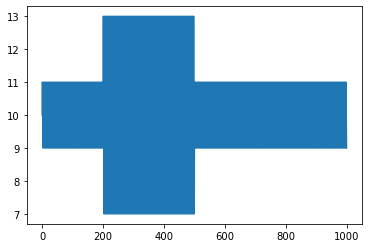

In [8]:
# x = np.random.randn(int(120/dt))
x = np.sin(0.5*np.pi*np.arange(int(10/dt)))

HC = 0.3
LC = 0.1
M = 10

x = x*LC
x[int(2/dt):int(5/dt)] = x[int(2/dt):int(5/dt)]*HC/LC
x = (x+1)*M

plt.plot(x)

# Subtraction + GC (Gain act on both)

In [9]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [10]:
B_e = 5000 #To tune altitude of gain control (D=1/T) 4000; 5000
tau_e = 0.1

B_s = 380 #To tune altitude of gain control (D=1/T) 320,340,375; 380,430,480
tau_s = 0.6

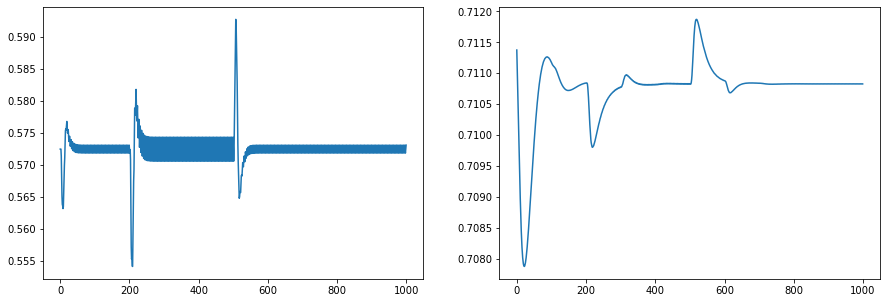

In [11]:
apapt_step = 2*len(k_E)

fig, ax = plt.subplots(1,2)

eOutput = np.convolve( np.hstack((np.ones(apapt_step)*M,x)), k_E, 'full')[:apapt_step+len(x)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*M,x)), k_S, 'full')[:apapt_step+len(x)]
eOutput_GC, gain_e = AddGainControl(eOutput, B_e, tau_e)    
ax[0].plot(gain_e[apapt_step:])
sOutput_GC, gain_s = AddGainControl(sOutput, B_s, tau_s)
ax[1].plot(gain_s[apapt_step:]) # make sure the value of gain is good
output = (-eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi)

fig.set_size_inches(15, 5)

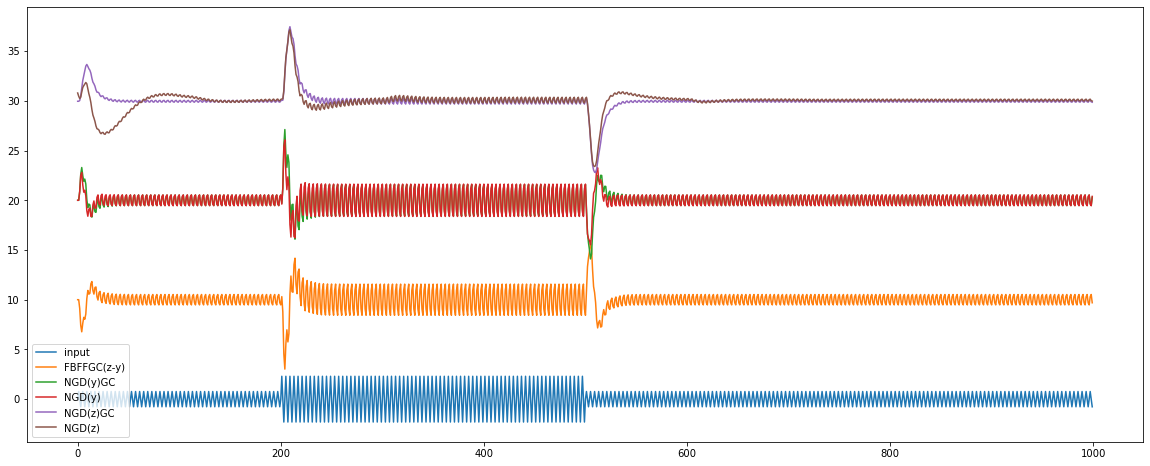

In [13]:
plt.plot((x-np.mean(x))/np.std(x) , label = 'input')
plt.plot((output-np.mean(output))/np.std(output) + 10 , label = 'FBFFGC(z-y)')
plt.plot((eOutput[apapt_step:]-np.mean(eOutput[apapt_step:]))/np.std(eOutput[apapt_step:])  + 2*10 , label = 'NGD(y)GC')
plt.plot((eOutput_GC[apapt_step:]-np.mean(eOutput_GC[apapt_step:]))/np.std(eOutput_GC[apapt_step:])  + 2*10 , label = 'NGD(y)')
plt.plot((sOutput[apapt_step:]-np.mean(sOutput[apapt_step:]))/np.std(sOutput[apapt_step:])  + 3*10 , label = 'NGD(z)GC')
plt.plot((sOutput_GC[apapt_step:]-np.mean(sOutput_GC[apapt_step:]))/np.std(sOutput_GC[apapt_step:])  + 3*10 , label = 'NGD(z)')
plt.legend()
plt.gcf().set_size_inches(20, 8)